In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


from astrodet import astrodet as toolkit
toolkit.init()

toolKit Loaded!


### Custom dataset

In [2]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode
import glob
from astropy.io import fits

def get_astro_dicts(img_dir):
    
    
    # It's weird to call this img_dir
    #set_dirs = glob.glob('%s/set_*' % img_dir)
    set_dirs = ['%s/set_%d' % (img_dir, i) for i in range(10)]
    
    dataset_dicts = []
    
    # Loop through each set
    for idx, set_dir in enumerate(set_dirs):
        record = {}
        
        mask_dir = os.path.join(img_dir, set_dir, "masks.fits")
        filename = os.path.join(img_dir, set_dir, "img")
        
        # Open each FITS image
        with fits.open(mask_dir, memmap=False, lazy_load_hdus=False) as hdul:
            sources = len(hdul)
            height, width = hdul[0].data.shape
            data = [hdu.data/np.max(hdu.data) for hdu in hdul]
            category_ids = [hdu.header["CLASS_ID"] for hdu in hdul]
            
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        
        # Mask value thresholds per category_id
        thresh = [0.005 if i == 1 else 0.08 for i in category_ids]
        
        # Generate segmentation masks
        for i in range(sources):
            image = data[i]
            mask = np.zeros([height, width], dtype=np.uint8)
            # Create mask from threshold
            mask[:,:][image > thresh[i]] = 1
            # Smooth mask
            mask[:,:] = cv2.GaussianBlur(mask[:,:], (9,9), 2)
            
            # https://github.com/facebookresearch/Detectron/issues/100
            mask_new, contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:
                x,y,w,h = cv2.boundingRect(contour)
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)
            # No valid countors
            if len(segmentation) == 0:
                continue
            
            # Add to dict
            obj = {
                "bbox": [x, y, w, h],
                "area": w*h,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i] - 1,
            }
            objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
         
    return dataset_dicts

# Register datasets
#yufeng 6/22
DatasetCatalog.register("astro_train", lambda: get_astro_dicts("/home/yufengl2/astro_rcnn/trainingset"))
MetadataCatalog.get("astro_train").set(thing_classes=["star", "galaxy"])
astro_metadata = MetadataCatalog.get("astro_train")
DatasetCatalog.register("astro_val", lambda: get_astro_dicts("/home/yufengl2/astro_rcnn/testset"))
#change the above line to run on test/validation set
MetadataCatalog.get("astro_val").set(thing_classes=["star", "galaxy"])
astro_metadata_val = MetadataCatalog.get("astro_val")

In [3]:
from detectron2.data import build_detection_train_loader

def read_image(filename, normalize='lupton', stretch=5, Q=10, m=0, ceil_percentile=99.995, dtype=np.uint8):
    # Read image
    # TODO: Combine these files into one img_0, mask_0 ... in simulate.py
    g = fits.getdata(os.path.join(filename+'_g.fits'), memmap=False)
    r = fits.getdata(os.path.join(filename+'_r.fits'), memmap=False)
    z = fits.getdata(os.path.join(filename+'_z.fits'), memmap=False)
    
    # Contrast scaling / normalization
    I = (z + r + g)/3.0
    
    length, width = g.shape
    image = np.empty([length, width, 3], dtype=dtype)
    
    # Options for contrast scaling
    if normalize.lower() == 'lupton':
        z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)
    elif normalize.lower() == 'zscore':
        Isigma = I*np.mean([np.nanstd(g), np.nanstd(r), np.nanstd(z)])
        z = (z - np.nanmean(z) - m)/Isigma
        r = (r - np.nanmean(r) - m)/Isigma
        g = (g - np.nanmean(g) - m)/Isigma
    elif normalize.lower() == 'linear':
        z = (z - m)/I
        r = (r - m)/I
        g = (g - m)/I
    else:
        print('Normalize keyword not recognized.')

    max_RGB = np.nanpercentile([z, r, g], ceil_percentile)
    # avoid saturation
    r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

    # Rescale to 0-255 for dtype=np.uint8
    max_dtype = np.iinfo(dtype).max
    r = r*max_dtype
    g = g*max_dtype
    z = z*max_dtype

    # 0-255 BGR image
    image[:,:,0] = g
    image[:,:,1] = r
    image[:,:,2] = z
    
    return image

### Visualize ground truth examples

127 instances
129 instances
135 instances


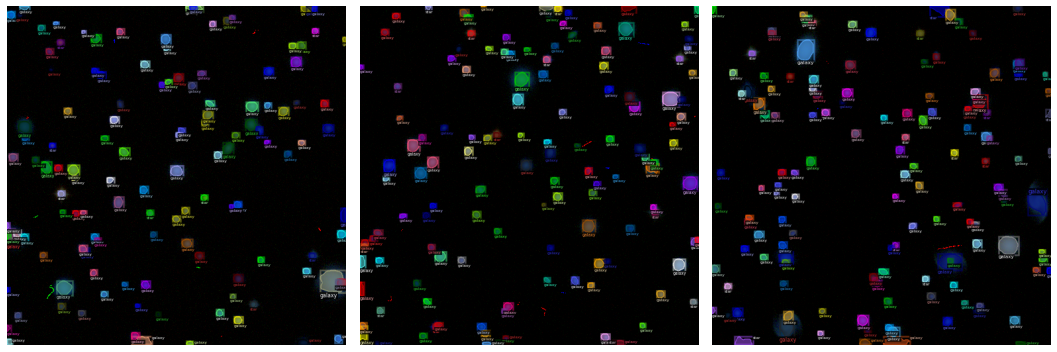

In [4]:
dataset_dicts = get_astro_dicts("/home/yufengl2/astro_rcnn/trainingset")

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts, nsample)):
    img = read_image(d["file_name"], normalize="zscore")
    print(len(d['annotations']), "instances")
    visualizer = Visualizer(img, metadata=astro_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

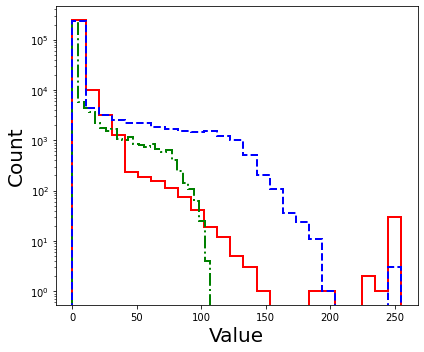

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
bins = 25
ax.hist(img[:,:,0].flatten(), histtype="step", bins=bins, log=True, color="r", lw=2, zorder=1);
ax.hist(img[:,:,1].flatten(), histtype="step", bins=bins, log=True, color="g", lw=2, linestyle='-.', zorder=2);
ax.hist(img[:,:,2].flatten(), histtype="step", bins=bins, log=True, color="b", lw=2, linestyle='dashed', zorder=3);
ax.set_xlabel('Value', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
fig.tight_layout()

### Re-Train

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from typing import Dict, List, Optional
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils
import weakref
import copy
import torch
import time

"""train_mapper implements data augmentation, test_mapper is just here for custom testing"""
def train_mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = read_image(dataset_dict["file_name"], normalize = 'zscore')
    augs = T.AugmentationList([
        T.RandomRotation([-90,90, 180], sample_style='choice'),
        T.RandomFlip(prob=0.5),
        T.Resize((512,512))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    transform = augs(auginput) # remove this?
    image = torch.from_numpy(auginput.image.transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:])
    }

def test_mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = read_image(dataset_dict["file_name"],normalize = 'zscore')
    augs = T.AugmentationList([
        T.Resize((512,512))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    transform = augs(auginput) # remove this?
    image = torch.from_numpy(auginput.image.transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:])
    }

### Visualize Augmented Data

/home/yufengl2/.conda/envs/colin1/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/apps/anaconda3/envs/opence-v.1.1.1/conda-bld/pytorch-base_1611680481078/work/torch/csrc/utils/tensor_numpy.cpp:141.)


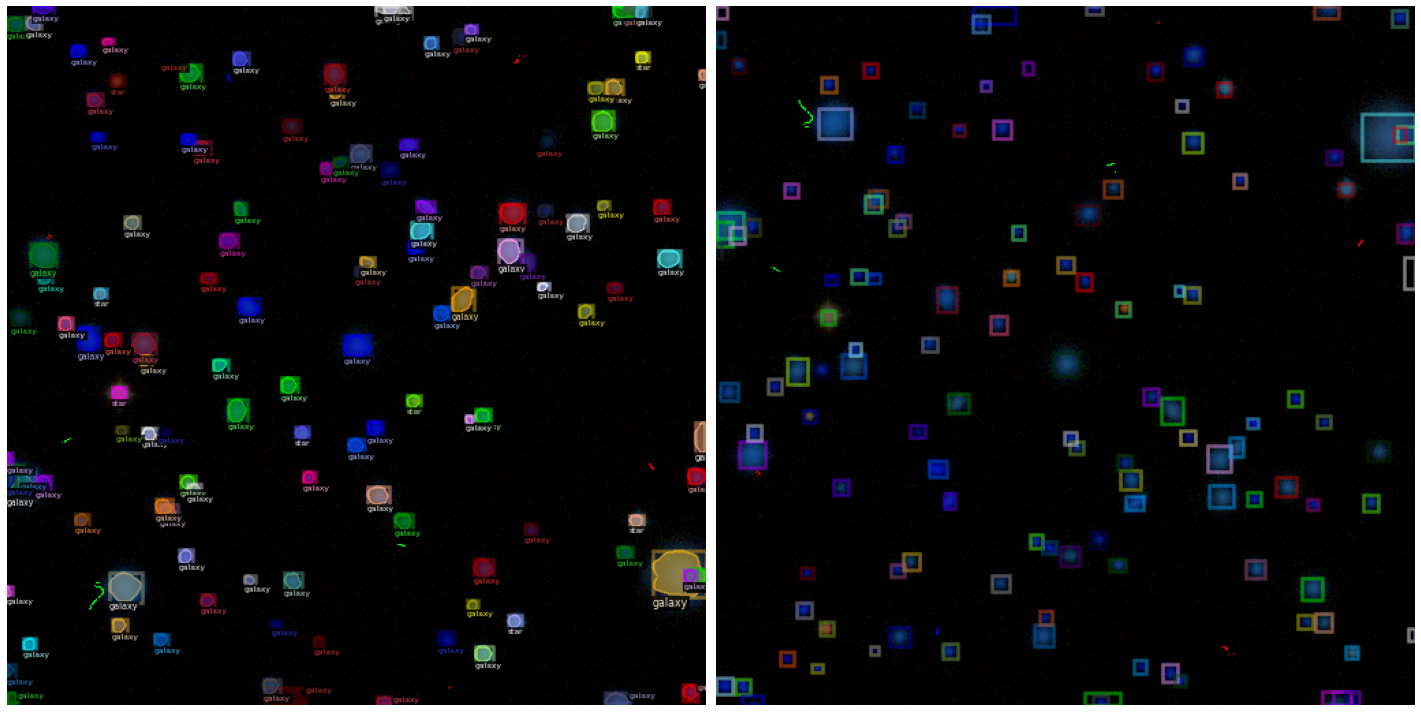

In [7]:
dataset_dicts = get_astro_dicts("/home/yufengl2/astro_rcnn/trainingset")
fig, axs = plt.subplots(1,2,figsize=(10*2, 10))

dictionary = iter(dataset_dicts)
d = next(dictionary)
img = read_image(d["file_name"], normalize="zscore")
visualizer = Visualizer(img, metadata=astro_metadata, scale=1)
out = visualizer.draw_dataset_dict(d)
axs[0].imshow(out.get_image())
axs[0].axis('off')
fig.tight_layout()
fig.show()

aug_data = train_mapper(d)
img_aug = aug_data["image"]
img_reshape = torch.zeros((512,512,3))
for i in range(3):
    img_reshape[:,:,i]= img_aug[i,:,:]
visualizer = Visualizer(img_reshape, metadata=astro_metadata, scale=1)
out = visualizer.overlay_instances(boxes = aug_data["instances"].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis('off')
fig.tight_layout()
fig.show()

### Prepare For Training

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")) # Get model structure
cfg.DATASETS.TRAIN = ("astro_train") # Register Metadata
cfg.DATASETS.TEST = ("astro_val") # Register Metadata
cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = '/home/yufengl2/astrodet2/astrodet/my_output/model_test_c4.pth'  #Let training initialize from a local model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.005  # pick a good LR#start from 0.005
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.MAX_ITER = 100    #for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = './my_output/'
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
saveHook = toolkit.SaveHook()
saveHook.set_output_name("model_temp")
hookList = [saveHook]



os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
loader = data.build_detection_train_loader(cfg, mapper=train_mapper)
print(type(optimizer))

[10/01 14:56:29 d2.data.build]: Removed 0 images with no usable annotations. 10 images left.
[10/01 14:56:29 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    star    | 138          |   galaxy   | 1185         |
|            |              |            |              |
|   total    | 1323         |            |              |
[10/01 14:56:29 d2.data.build]: Using training sampler TrainingSampler
[10/01 14:56:29 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[10/01 14:56:29 d2.data.common]: Serialized dataset takes 0.16 MiB
<class 'torch.optim.sgd.SGD'>


In [9]:
trainer = toolkit.AstroTrainer(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)
trainer.set_period(25) # print loss every 25 iterations
trainer.train(0,100) #100 iterations gives a loss roughly at 1.1



Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (3, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (8, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[10/01 14:56:29 d2.engine.train_loop]: Starting training from iteration 0


/home/yufengl2/.conda/envs/colin1/lib/python3.6/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/apps/anaconda3/envs/opence-v.1.1.1/conda-bld/pytorch-base_1611680481078/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


Iteration:  25  time:  1.9650906324386597e-07  loss:  tensor(1.6415, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  50  time:  2.421438694000244e-07  loss:  tensor(1.4558, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  75  time:  2.3562461137771606e-07  loss:  tensor(1.2883, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  100  time:  2.4400651454925537e-07  loss:  tensor(1.2622, device='cuda:0', grad_fn=<AddBackward0>)


### Plot The Loss

[tensor(1.3419, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.2474, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.3420, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.2042, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.2908, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.2819, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.2390, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.2970, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.2621, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.2622, device='cuda:0', grad_fn=<AddBackward0>)]

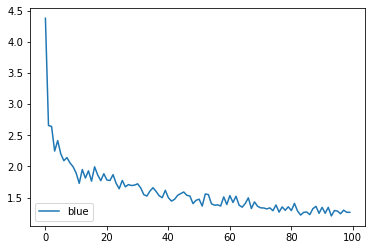

In [10]:
import matplotlib.pyplot as plt
import numpy as np
lossList = trainer.lossList #extract the loss
plt.plot(lossList)
plt.legend(['blue'], loc = 'lower left')
lossList[-10:] # print last 10 loss values

In [14]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output --host localhost

Launching TensorBoard...

KeyboardInterrupt: 

### Inference

In [12]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_temp.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

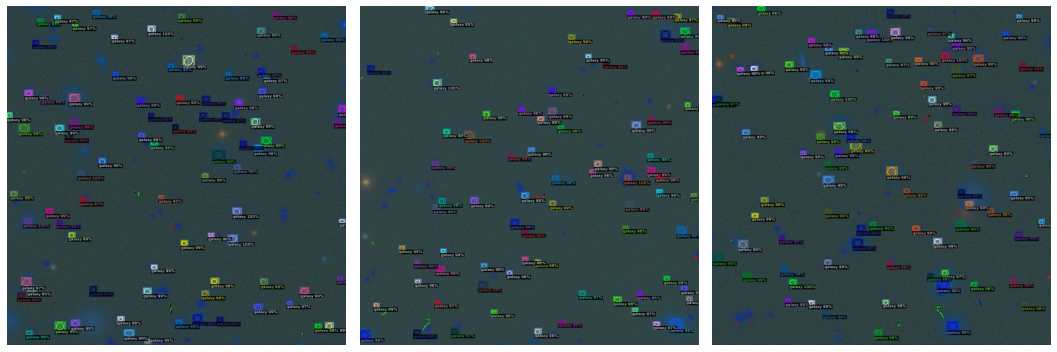

In [13]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_astro_dicts("/home/yufengl2/astro_rcnn/testset") # Replace this with the validation dataset

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts, nsample)):
    im = read_image(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im,
                   metadata=astro_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

total instances: 143
detected instances: 123
total instances: 120
detected instances: 106
total instances: 151
detected instances: 128


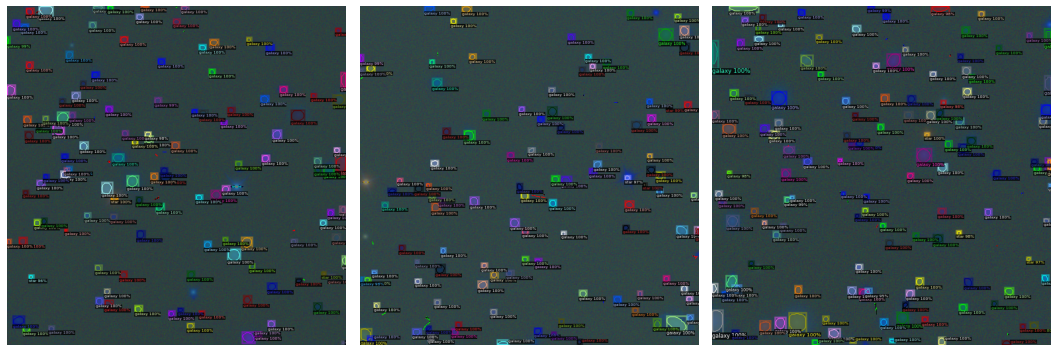

In [9]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_astro_dicts("/home/yufengl2/astro_rcnn/testset") # Replace this with the validation dataset

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts, nsample)):
    print('total instances:', len(d['annotations']))
    im = read_image(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    print('detected instances:',len(outputs['instances'].pred_boxes))
    v = Visualizer(im,
                   metadata=astro_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

### Evaluate

In [14]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = toolkit.COCOEvaluatorRecall("astro_val", cfg, False, output_dir="./my_output/") # Should be astro_val
val_loader = build_detection_test_loader(cfg, "astro_val", mapper=test_mapper) #It references to cfg.DATASETS.TEST
# dataset_dicts = get_astro_dicts("/home/yufengl2/astro_rcnn/testset")
# val_loader = build_detection_test_loader(dataset_dicts, mapper=mapper)
#The two loader implementations are equivalent
results = inference_on_dataset(model, val_loader, evaluator) #yufeng 6/22  changed from trainer.model to model
#print(results)

WARNING [10/01 14:59:19 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/01 14:59:19 d2.evaluation.coco_evaluation]: 'astro_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[10/01 14:59:19 d2.data.datasets.coco]: Converting annotations of dataset 'astro_val' to COCO format ...)
[10/01 14:59:26 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[10/01 14:59:26 d2.data.datasets.coco]: Conversion finished, #images: 10, #annotations: 1444
[10/01 14:59:26 d2.data.datasets.coco]: Caching COCO format annotations at './my_output/astro_val_coco_format.json' ...
[10/01 14:59:33 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    star    | 147          |   galaxy   | 1297         |
|            | 

In [15]:
# Now get the precision
# precision has dims (iou, recall, cls, area range, max dets)
results_per_category = results['segm']['results_per_category']
#for ca in 
precision_star = results_per_category[0]
precision_galaxy = results_per_category[1]
print(np.shape(precision_star))
#print(precision_star)
print(precision_star[0,:,0,0,-1])

(10, 101, 2, 4, 3)
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.94444444 0.94444444 0.94444444 0.94444444 0.94444444
 0.9        0.89130435 0.89130435 0.89130435 0.875      0.86
 0.8490566  0.8245614  0.81967213 0.81967213 0.81967213 0.76811594
 0.76811594 0.75342466 0.72727273 0.70731707 0.69318182 0.69318182
 0.69148936 0.69148936 0.69148936 0.68367347 0.64150943 0.63636364
 0.61206897 0.592      0.592      0.5033557  0.49681529 0.49681529
 0.47337278 0.41919192 0.41919192 0.38116592 0.37391304 0.36401674
 0.32720588 0.27777778 0.27627628 0.26724138 0.24934383 0.22018349
 0.20851064 0.18165138 0.17482517 0.1418637  0.14032698 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

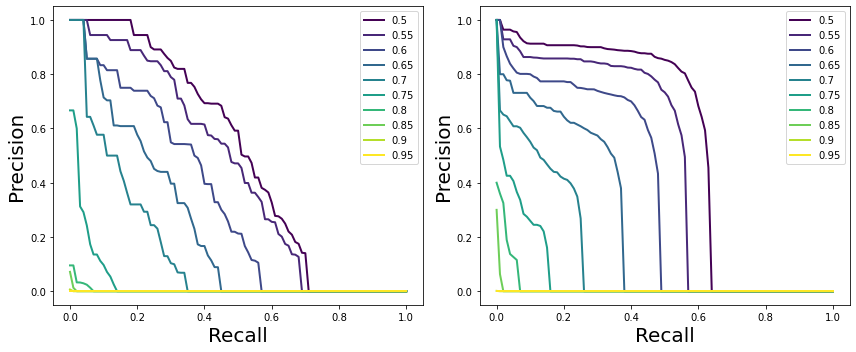

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.flatten()

ious = np.linspace(0.50,0.95,10)
colors = plt.cm.viridis(np.linspace(0,1,len(ious)))
#note: maxdet set to 2
# Plot precision recall
for j, precision_class in enumerate([precision_star, precision_galaxy]):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        # What are the IoU levels?
        p = precision_class[i, :, j, 0, -1]
        r = np.linspace(0, 1, precision_shape[1]) # i think
        mask = (p >-1)
        #redundant because p always>-1
        p = p[mask]
        r = r[mask]
        # Plot
        iou = np.around(ious[i], 2)
        #axs[j].plot(r, p, label=f'{iou}', color=colors[i],lw=2) # use a viridis color scheme
        axs[j].plot(r, p, label=f'{iou}', color=colors[i],lw=2) # use a viridis color scheme
        axs[j].set_xlabel('Recall', fontsize=20)
        axs[j].set_ylabel('Precision', fontsize=20)
        axs[j].legend(fontsize=10)
        
fig.tight_layout()

# BackUp

In [8]:
"""Note:SaveHook is in charge of saving the trained model"""
class SaveHook(HookBase):
    def after_train(self):
        self.trainer.checkpointer.save("model_test_temp") # Note: Set the name of the output model here
class AstroTrainer(SimpleTrainer):
    def __init__(self, model, data_loader, optimizer):
        super().__init__(model, data_loader, optimizer)
        
        # Borrowed from DefaultTrainer constructor
        # see https://detectron2.readthedocs.io/en/latest/_modules/detectron2/engine/defaults.html#DefaultTrainer
        self.checkpointer = checkpointer.DetectionCheckpointer(
            # Assume you want to save checkpoints together with logs/statistics
            model,
            cfg.OUTPUT_DIR
        )
        # load weights
        self.checkpointer.load(cfg.MODEL.WEIGHTS)
        
        # record loss over iteration 
        self.lossList = []
        
        self.period = 20
        self.iterCount = 0
    
    #Note: print out loss over p iterations
    def set_period(self,p):
        self.period = p
        
    # Copied directly from SimpleTrainer, add in custom manipulation with the loss
    # see https://detectron2.readthedocs.io/en/latest/_modules/detectron2/engine/train_loop.html#SimpleTrainer
    def run_step(self):
        self.iterCount = self.iterCount + 1
        assert self.model.training, "[SimpleTrainer] model was changed to eval mode!"
        start = time.perf_counter()
        data_time = time.perf_counter() - start
        data = next(self._data_loader_iter)
        # Note: in training mode, model() returns loss
        loss_dict = self.model(data)
        if isinstance(loss_dict, torch.Tensor):
            losses = loss_dict
            loss_dict = {"total_loss": loss_dict}
        else:
            losses = sum(loss_dict.values())
        self.optimizer.zero_grad()
        losses.backward()
        self.optimizer.step()
        self.lossList.append(losses)
        if self.iterCount % self.period == 0:
            print("Iteration: ", self.iterCount, " time: ", data_time," loss: ",losses)



In [12]:
# Override COCOEvaluator to return precision-recall information
import contextlib
import copy
import io
import itertools
import json
import logging
import numpy as np
import os
import pickle
from collections import OrderedDict
import pycocotools.mask as mask_util
import torch
import datetime
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tabulate import tabulate

import detectron2.utils.comm as comm
#yufeng 6/11 import cocoevaluator
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.config import CfgNode
from detectron2.data import MetadataCatalog
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation.fast_eval_api import COCOeval_opt
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import create_small_table



class COCOeval_opt_custom(COCOeval_opt):
    def evaluate_custom(self):
        '''
        Run per image evaluation on given images and store results (a list of dict) in self.evalImgs
        :return: None
        '''
        tic = time.time()
        print('Running per image evaluation...')
        p = self.params
        # add backward compatibility if useSegm is specified in params
        if not p.useSegm is None:
            p.iouType = 'segm' if p.useSegm == 1 else 'bbox'
            print('useSegm (deprecated) is not None. Running {} evaluation'.format(p.iouType))
        print('Evaluate annotation type *{}*'.format(p.iouType))
        p.imgIds = list(np.unique(p.imgIds))
        if p.useCats:
            p.catIds = list(np.unique(p.catIds))
        p.maxDets = sorted(p.maxDets)
        self.params=p

        self._prepare()
        # loop through images, area range, max detection number
        catIds = p.catIds if p.useCats else [-1]

        if p.iouType == 'segm' or p.iouType == 'bbox':
            computeIoU = self.computeIoU
        elif p.iouType == 'keypoints':
            computeIoU = self.computeOks
        self.ious = {(imgId, catId): computeIoU(imgId, catId) \
                        for imgId in p.imgIds
                        for catId in catIds}

        evaluateImg = self.evaluateImg
        maxDet = p.maxDets[-1]
        self.evalImgs = [evaluateImg(imgId, catId, areaRng, maxDet)
                 for catId in catIds
                 for areaRng in p.areaRng
                 for imgId in p.imgIds
             ]
        self._paramsEval = copy.deepcopy(self.params)
        toc = time.time()
        print('DONE (t={:0.2f}s).'.format(toc-tic))
    def accumulate_custom(self, p = None):
        '''
        Accumulate per image evaluation results and store the result in self.eval
        :param p: input params for evaluation
        :return: None
        '''
        print('Accumulating evaluation results...')
        tic = time.time()
        if not self.evalImgs:
            print('Please run evaluate() first')
        # allows input customized parameters
        if p is None:
            p = self.params
        p.catIds = p.catIds if p.useCats == 1 else [-1]
        T           = len(p.iouThrs)
        R           = len(p.recThrs)
        K           = len(p.catIds) if p.useCats else 1
        A           = len(p.areaRng)
        M           = len(p.maxDets)
        precision   = -np.ones((T,R,K,A,M)) # -1 for the precision of absent categories
        recall      = -np.ones((T,K,A,M))
        scores      = -np.ones((T,R,K,A,M))
        
        precision_raw   = -np.ones((T,R,K,A,M))
        recall_raw      = -np.ones((T,R,K,A,M))

        # create dictionary for future indexing
        _pe = self._paramsEval
        catIds = _pe.catIds if _pe.useCats else [-1]
        setK = set(catIds)
        setA = set(map(tuple, _pe.areaRng))
        setM = set(_pe.maxDets)
        setI = set(_pe.imgIds)
        # get inds to evaluate
        k_list = [n for n, k in enumerate(p.catIds)  if k in setK]
        m_list = [m for n, m in enumerate(p.maxDets) if m in setM]
        a_list = [n for n, a in enumerate(map(lambda x: tuple(x), p.areaRng)) if a in setA]
        i_list = [n for n, i in enumerate(p.imgIds)  if i in setI]
        I0 = len(_pe.imgIds)
        A0 = len(_pe.areaRng)
        # retrieve E at each category, area range, and max number of detections
        for k, k0 in enumerate(k_list):
            Nk = k0*A0*I0
            for a, a0 in enumerate(a_list):
                Na = a0*I0
                for m, maxDet in enumerate(m_list):
                    E = [self.evalImgs[Nk + Na + i] for i in i_list]
                    E = [e for e in E if not e is None]
                    if len(E) == 0:
                        continue
                    dtScores = np.concatenate([e['dtScores'][0:maxDet] for e in E])

                    # different sorting method generates slightly different results.
                    # mergesort is used to be consistent as Matlab implementation.
                    inds = np.argsort(-dtScores, kind='mergesort')
                    dtScoresSorted = dtScores[inds]

                    dtm  = np.concatenate([e['dtMatches'][:,0:maxDet] for e in E], axis=1)[:,inds]
                    dtIg = np.concatenate([e['dtIgnore'][:,0:maxDet]  for e in E], axis=1)[:,inds]
                    gtIg = np.concatenate([e['gtIgnore'] for e in E])
                    npig = np.count_nonzero(gtIg==0 )
                    if npig == 0:
                        continue
                    tps = np.logical_and(               dtm,  np.logical_not(dtIg) )
                    fps = np.logical_and(np.logical_not(dtm), np.logical_not(dtIg) )

                    tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
                    fp_sum = np.cumsum(fps, axis=1).astype(dtype=np.float)
                    for t, (tp, fp) in enumerate(zip(tp_sum, fp_sum)):
                        tp = np.array(tp)
                        fp = np.array(fp)
                        nd = len(tp)
                        rc = tp / npig
                        pr = tp / (fp+tp+np.spacing(1))
                        q  = np.zeros((R,))
                        ss = np.zeros((R,))
                        if nd:
                            recall[t,k,a,m] = rc[-1]
                        else:
                            recall[t,k,a,m] = 0

                        # numpy is slow without cython optimization for accessing elements
                        # use python array gets significant speed improvement
                        pr = pr.tolist(); q = q.tolist()

                        for i in range(nd-1, 0, -1):
                            if pr[i] > pr[i-1]:
                                pr[i-1] = pr[i]

                        inds = np.searchsorted(rc, p.recThrs, side='left')
                        try:
                            for ri, pi in enumerate(inds):
                                q[ri] = pr[pi]
                                ss[ri] = dtScoresSorted[pi]
                        except:
                            pass
                        precision[t,:,k,a,m] = np.array(q)
                        scores[t,:,k,a,m] = np.array(ss)
        self.eval = {
            'params': p,
            'counts': [T, R, K, A, M],
            'date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'precision': precision,
            'recall':   recall,
            'scores': scores,
        }
        toc = time.time()
        print('DONE (t={:0.2f}s).'.format( toc-tic))






"""I override this function just to set maxDets to 200"""
def _evaluate_predictions_on_coco(
        coco_gt, coco_results, iou_type, kpt_oks_sigmas=None, use_fast_impl=True, img_ids=None
    ):
        
        #Evaluate the coco results using COCOEval API.
        assert len(coco_results) > 0
        print("_evaluate_predictions_on_coco")
        #6/27 this override function is not called
        if iou_type == "segm":
            coco_results = copy.deepcopy(coco_results)
            # When evaluating mask AP, if the results contain bbox, cocoapi will
            # use the box area as the area of the instance, instead of the mask area.
            # This leads to a different definition of small/medium/large.
            # We remove the bbox field to let mask AP use mask area.
            for c in coco_results:
                c.pop("bbox", None)
        
        coco_dt = coco_gt.loadRes(coco_results)
        coco_eval = (COCOeval_opt_custom if use_fast_impl else COCOeval)(coco_gt, coco_dt, iou_type)
        print("++++++++++",type(coco_eval))
        if img_ids is not None:
            coco_eval.params.imgIds = img_ids
            
        
        if iou_type == "keypoints":
            # Use the COCO default keypoint OKS sigmas unless overrides are specified
            if kpt_oks_sigmas:
                assert hasattr(coco_eval.params, "kpt_oks_sigmas"), "pycocotools is too old!"
                coco_eval.params.kpt_oks_sigmas = np.array(kpt_oks_sigmas)
            # COCOAPI requires every detection and every gt to have keypoints, so
            # we just take the first entry from both
            num_keypoints_dt = len(coco_results[0]["keypoints"]) // 3
            num_keypoints_gt = len(next(iter(coco_gt.anns.values()))["keypoints"]) // 3
            num_keypoints_oks = len(coco_eval.params.kpt_oks_sigmas)
            assert num_keypoints_oks == num_keypoints_dt == num_keypoints_gt, (
                f"[COCOEvaluator] Prediction contain {num_keypoints_dt} keypoints. "
                f"Ground truth contains {num_keypoints_gt} keypoints. "
                f"The length of cfg.TEST.KEYPOINT_OKS_SIGMAS is {num_keypoints_oks}. "
                "They have to agree with each other. For meaning of OKS, please refer to "
                "http://cocodataset.org/#keypoints-eval."
            )
        coco_eval.params.maxDets = [1,10,200] # by default it is [1,10,100], our datasets have more than 100 instances
        coco_eval.evaluate_custom()
        coco_eval.accumulate_custom()
        coco_eval.summarize()
        return coco_eval
    

    
class COCOEvaluatorRecall(COCOEvaluator):
    """I override this class in order to call the custom function above"""
    def _eval_predictions(self, predictions, img_ids=None):
        
        #Evaluate predictions. Fill self._results with the metrics of the tasks.
        
        self._logger.info("Preparing results for COCO format ...")
        coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))
        tasks = self._tasks or self._tasks_from_predictions(coco_results)

        # unmap the category ids for COCO
        if hasattr(self._metadata, "thing_dataset_id_to_contiguous_id"):
            dataset_id_to_contiguous_id = self._metadata.thing_dataset_id_to_contiguous_id
            all_contiguous_ids = list(dataset_id_to_contiguous_id.values())
            num_classes = len(all_contiguous_ids)
            assert min(all_contiguous_ids) == 0 and max(all_contiguous_ids) == num_classes - 1

            reverse_id_mapping = {v: k for k, v in dataset_id_to_contiguous_id.items()}
            for result in coco_results:
                category_id = result["category_id"]
                assert category_id < num_classes, (
                    f"A prediction has class={category_id}, "
                    f"but the dataset only has {num_classes} classes and "
                    f"predicted class id should be in [0, {num_classes - 1}]."
                )
                result["category_id"] = reverse_id_mapping[category_id]

        if self._output_dir:
            file_path = os.path.join(self._output_dir, "coco_instances_results.json")
            self._logger.info("Saving results to {}".format(file_path))
            with PathManager.open(file_path, "w") as f:
                f.write(json.dumps(coco_results))
                f.flush()

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info(
            "Evaluating predictions with {} COCO API...".format(
                "unofficial" if self._use_fast_impl else "official"
            )
        )
        for task in sorted(tasks):
            assert task in {"bbox", "segm", "keypoints"}, f"Got unknown task: {task}!"
            print(self._kpt_oks_sigmas)
            coco_eval = (
                _evaluate_predictions_on_coco(
                    self._coco_api,
                    coco_results,
                    task,
                    kpt_oks_sigmas = None,
                    use_fast_impl=self._use_fast_impl,
                    img_ids=img_ids,
                )
                if len(coco_results) > 0
                else None  # cocoapi does not handle empty results very well
            )

            res = self._derive_coco_results(
                coco_eval, task, class_names=self._metadata.get("thing_classes")
            )
            self._results[task] = res
            
    
    
    
    def _derive_coco_results(self, coco_eval, iou_type, class_names=None):
        
        #Derive the desired score numbers from summarized COCOeval.

        """Args:
            coco_eval (None or COCOEval): None represents no predictions from model.
            iou_type (str):
            class_names (None or list[str]): if provided, will use it to predict
                per-category AP.

        Returns:
            a dict of {metric name: score}"""
        
        print("++++++++derive_coco_results")
        metrics = {
            "bbox": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "segm": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "keypoints": ["AP", "AP50", "AP75", "APm", "APl"],
            }[iou_type]

        if coco_eval is None:
            self._logger.warn("No predictions from the model!")
            return {metric: float("nan") for metric in metrics}
        # the standard metrics
        print(type(coco_eval))
        results = {
            metric: float(coco_eval.stats[idx] * 100 if coco_eval.stats[idx] >= 0 else "nan")
            for idx, metric in enumerate(metrics)
            }
        self._logger.info(
            "Evaluation results for {}: \n".format(iou_type) + create_small_table(results)
            )
        if not np.isfinite(sum(results.values())):
            self._logger.info("Some metrics cannot be computed and is shown as NaN.")

        if class_names is None or len(class_names) <= 1:
            return results
        # Compute per-category AP
        # from https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L222-L252 # noqa
        precisions = coco_eval.eval["precision"]
        # precision has dims (iou, recall, cls, area range, max dets)
        assert len(class_names) == precisions.shape[2]

        results_per_category = []
        precision_per_category = []
        for idx, name in enumerate(class_names):
            # area range index 0: all area ranges
            # max dets index -1: typically 100 per image
            precision = precisions[:, :, idx, 0, -1]
            precision = precision[precision > -1]
            precision_per_category.append(precisions)
            ap = np.mean(precision) if precision.size else float("nan")
            results_per_category.append(("{}".format(name), float(ap * 100)))

        # tabulate it
        N_COLS = min(6, len(results_per_category) * 2)
        results_flatten = list(itertools.chain(*results_per_category))
        results_2d = itertools.zip_longest(*[results_flatten[i::N_COLS] for i in range(N_COLS)])
        table = tabulate(
            results_2d,
            tablefmt="pipe",
            floatfmt=".3f",
            headers=["category", "AP"] * (N_COLS // 2),
            numalign="left",
            )
        self._logger.info("Per-category {} AP: \n".format(iou_type) + table)
        
        # Save the precision-recall per category
        results["results_per_category"] = precision_per_category

        results.update({"AP-" + name: ap for name, ap in results_per_category})
        return results